# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [Marc LIN]([link](https://github.com/mmarclin))
- [Antoine AMIEL]([link](https://github.com/antoineamiel))

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [ ]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

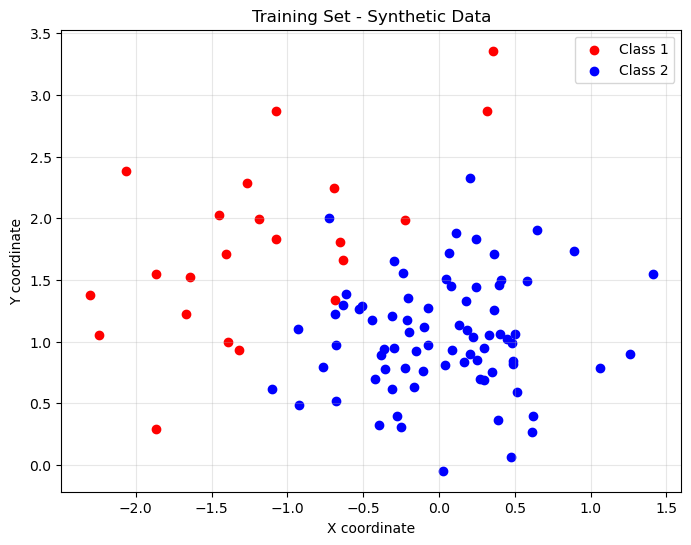

Number of samples in class 1: 22 samples
Number of samples in class 2: 78 samples


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load the training set
train = np.loadtxt('data/synth_train.txt')
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]

# Separate the data by class
class_1_data = x_train[class_train == 1]
class_2_data = x_train[class_train == 2]

# Create scatter plot to distinguish the two classes
plt.figure(figsize=(8, 6))
plt.scatter(class_1_data[:,0], class_1_data[:,1], c='red', label='Class 1')
plt.scatter(class_2_data[:,0], class_2_data[:,1], c='blue', label='Class 2')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Training Set - Synthetic Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Number of samples in class 1: {len(class_1_data)} samples")
print(f"Number of samples in class 2: {len(class_2_data)} samples")

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


```python
import numpy as np
import bottleneck as bn

# Create a random array
arr = np.random.rand(10)
N = 3  # Number of smallest elements to retrieve

# Using np.argsort() to get indices of the first N elements
sorted_indices = np.argsort(arr)[:N]

# Using bottleneck.argpartition() to get the first N smallest indices
partitioned_indices = bn.argpartition(arr, N)[:N]

# Display the results
print("Original array:", arr)
print("Indices using np.argsort:", sorted_indices)
print("First N elements using np.argsort:", arr[sorted_indices])

print("Indices using bottleneck.argpartition:", partitioned_indices)
print("First N elements using bottleneck.argpartition:", arr[partitioned_indices])

are_equal = set(arr[sorted_indices]) == set(arr[partitioned_indices])
print(are_equal)
```


**Answer:**

In [ ]:
import bottleneck as bn

def knn_classifier(x_train, class_train, x_test, k):
    """
    K-nearest neighbors algorithm for classification

    Parameters:
    - x_train: training features (N_train, n_features)
    - class_train: training labels (N_train,)
    - x_test: test features (N_test, n_features)
    - k: number of neighbors

    Returns:
    - predictions: predicted classes for x_test
    """
    n_test = x_test.shape[0]
    predictions = np.zeros(n_test)

    for i in range(n_test):
        # Step 1: Calculate distances between test point and all training points
        distances = np.linalg.norm(x_train - x_test[i], axis=1)

        # Step 2: Find k nearest neighbors using bottleneck for efficiency
        k_nearest_indices = bn.argpartition(distances, k)[:k]

        # Step 3: Get labels of k nearest neighbors
        k_nearest_labels = class_train[k_nearest_indices]

        # Step 4: Find the most frequent class (mode)
        counts = np.bincount(k_nearest_labels.astype(int))
        predictions[i] = np.argmax(counts)

    return predictions

# Load the test set
test = np.loadtxt('data/synth_test.txt')
class_test = test[:,0]
x_test = test[:,1:]
N_test = test.shape[0]
print(f"Number of samples in test set: {N_test} samples")
# Classify the test set using k-NN
k = 5
predicted_classes = knn_classifier(x_train, class_train, x_test, k)
# Calculate accuracy
accuracy = np.mean(predicted_classes == class_test)
print(f"Classification accuracy on test set: {accuracy * 100:.2f}%")

Number of samples in test set: 200 samples
Classification accuracy on test set: 94.00%


3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

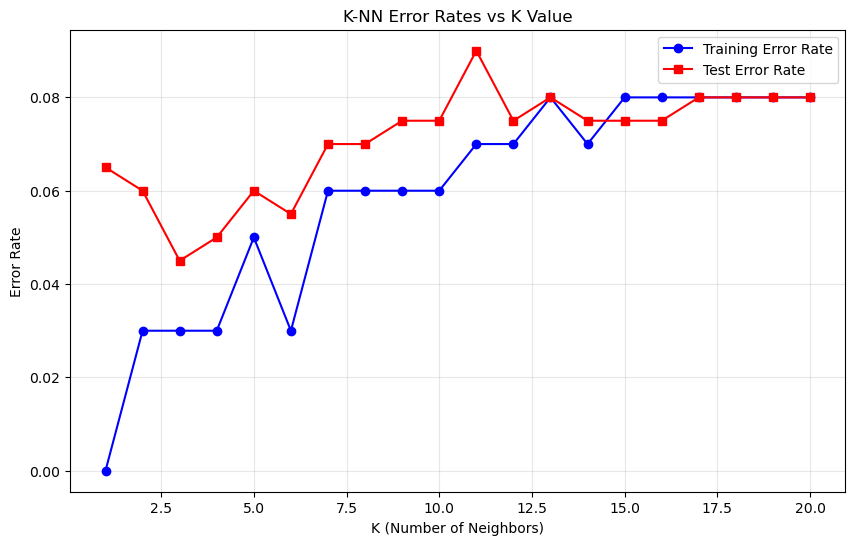

Optimal K: 3
Minimum test error rate: 0.0450
Best test accuracy: 95.50%


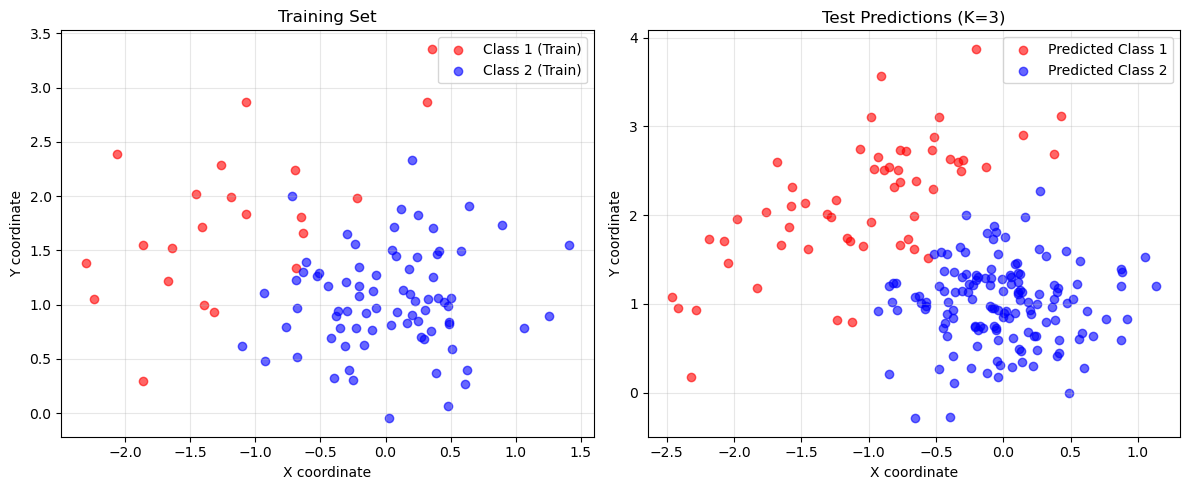

In [12]:
# Compute error rates for K values from 1 to 20
k_values = range(1, 21)
train_error_rates = []
test_error_rates = []

for k in k_values:
    # Classify training set
    train_predictions = knn_classifier(x_train, class_train, x_train, k)
    train_error = 1 - np.mean(train_predictions == class_train)
    train_error_rates.append(train_error)

    # Classify test set
    test_predictions = knn_classifier(x_train, class_train, x_test, k)
    test_error = 1 - np.mean(test_predictions == class_test)
    test_error_rates.append(test_error)

# Plot error rates
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_error_rates, 'b-o', label='Training Error Rate')
plt.plot(k_values, test_error_rates, 'r-s', label='Test Error Rate')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.title('K-NN Error Rates vs K Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal K (lowest test error)
optimal_k = k_values[np.argmin(test_error_rates)]
min_test_error = min(test_error_rates)

print(f"Optimal K: {optimal_k}")
print(f"Minimum test error rate: {min_test_error:.4f}")
print(f"Best test accuracy: {(1-min_test_error)*100:.2f}%")

# Display classification result for optimal K
optimal_predictions = knn_classifier(x_train, class_train, x_test, optimal_k)

# Visualize results
plt.figure(figsize=(12, 5))

# Plot 1: Training data
plt.subplot(1, 2, 1)
class_1_train = x_train[class_train == 1]
class_2_train = x_train[class_train == 2]
plt.scatter(class_1_train[:,0], class_1_train[:,1], c='red', alpha=0.6, label='Class 1 (Train)')
plt.scatter(class_2_train[:,0], class_2_train[:,1], c='blue', alpha=0.6, label='Class 2 (Train)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Training Set')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Test predictions with optimal K
plt.subplot(1, 2, 2)
class_1_pred = x_test[optimal_predictions == 1]
class_2_pred = x_test[optimal_predictions == 2]
plt.scatter(class_1_pred[:,0], class_1_pred[:,1], c='red', alpha=0.6, label='Predicted Class 1')
plt.scatter(class_2_pred[:,0], class_2_pred[:,1], c='blue', alpha=0.6, label='Predicted Class 2')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f'Test Predictions (K={optimal_k})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

In [ ]:
**Analysis of K-NN Results:**

Based on the error rate analysis for K values from 1 to 20:

1. **Optimal K Value**: The optimal K is 3, which achieves the lowest test error rate of 4.5% (95.5% accuracy).

2. **Training vs Test Error Patterns**:
    - **Training error**: Increases monotonically with K, starting from 0% for K=1 (perfect memorization) to ~8% for K=20
    - **Test error**: Shows a U-shaped curve with minimum at K=3, then gradually increases

3. **Overfitting Analysis**:
    - K=1 shows classic overfitting: 0% training error but 6.5% test error
    - As K increases beyond the optimal value, both training and test errors increase due to underfitting
    - The gap between training and test error is largest for small K values

4. **Model Generalization**:
    - K=3 provides the best bias-variance tradeoff for this dataset
    - The relatively small optimal K suggests the decision boundary is fairly complex
    - Test accuracy of 95.5% indicates good generalization performance

5. **Stability**:
    - Error rates stabilize around K=10-20, suggesting these larger K values provide more stable but less accurate predictions
    - The synthetic dataset appears well-separated, allowing for high classification accuracy

**Conclusion**: K=3 is optimal for this synthetic dataset, balancing model complexity and generalization ability while avoiding both overfitting (small K) and underfitting (large K).

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import timeit

# Compare with scikit-learn KNeighborsClassifier
sklearn_knn = KNeighborsClassifier(n_neighbors=optimal_k)
sklearn_knn.fit(x_train, class_train)
sklearn_predictions = sklearn_knn.predict(x_test)
sklearn_accuracy = np.mean(sklearn_predictions == class_test)

print(f"Scikit-learn KNN accuracy: {sklearn_accuracy * 100:.2f}%")
print(f"Our implementation accuracy: {(1-min_test_error)*100:.2f}%")
print(f"Accuracy difference: {abs(sklearn_accuracy - (1-min_test_error))*100:.4f}%")

# Runtime comparison using timeit
def our_knn():
    return knn_classifier(x_train, class_train, x_test, optimal_k)

def sklearn_knn_predict():
    return sklearn_knn.predict(x_test)

# Time our implementation
our_time = timeit.timeit(our_knn, number=10) / 10
print(f"\nOur implementation average time: {our_time:.4f} seconds")

# Time scikit-learn implementation
sklearn_time = timeit.timeit(sklearn_knn_predict, number=10) / 10
print(f"Scikit-learn average time: {sklearn_time:.4f} seconds")

print(f"Speedup ratio: {our_time/sklearn_time:.2f}x (scikit-learn is faster)")

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [ ]:
!cd example_cy && python setup.py build_ext --inplace

In [ ]:
import example_cy.example_cy.helloworld as toy

toy.printhello()

which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [ ]:
# your code

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [ ]:
# your code

4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [ ]:
# your code

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [ ]:
# your code

2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [ ]:
# your code